<a href="https://colab.research.google.com/github/AIBYTECH/Phython/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 92% 61.0M/66.0M [00:00<00:00, 98.6MB/s]
100% 66.0M/66.0M [00:00<00:00, 99.6MB/s]


In [ ]:
!unzip /content/creditcardfraud.zip

Archive:  /content/creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold, train_test_split
#from sklearnex import patch_sklearn  #This is a library to accelerate existing scikit-learn code
#patch_sklearn() #For more info: https://github.com/intel/scikit-learn-intelex

from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import xgboost as xgb
#from mlxtend.classifier import StackingCVClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, power_transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.pipeline import make_pipeline
#from imblearn.under_sampling import RandomUnde
from imblearn.over_sampling import ADASYN
import hyperopt 
from hyperopt.pyll import scope
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from warnings import filterwarnings

filterwarnings("ignore")
np.random.seed(0)

In [ ]:
df = pd.read_csv("creditcard.csv")

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.count()

Time      284807
V1        284807
V2        284807
V3        284807
V4        284807
V5        284807
V6        284807
V7        284807
V8        284807
V9        284807
V10       284807
V11       284807
V12       284807
V13       284807
V14       284807
V15       284807
V16       284807
V17       284807
V18       284807
V19       284807
V20       284807
V21       284807
V22       284807
V23       284807
V24       284807
V25       284807
V26       284807
V27       284807
V28       284807
Amount    284807
Class     284807
dtype: int64

In [ ]:
str(df)

'            Time         V1         V2        V3        V4        V5  \\\n0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   \n1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   \n2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   \n3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   \n4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   \n...          ...        ...        ...       ...       ...       ...   \n284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   \n284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   \n284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   \n284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   \n284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   \n\n              V6        V7        V8        V9  ...       V21       V22  \\\n0       0.462388  0.239599  0.098698  0.363

<Axes: xlabel='Class', ylabel='count'>

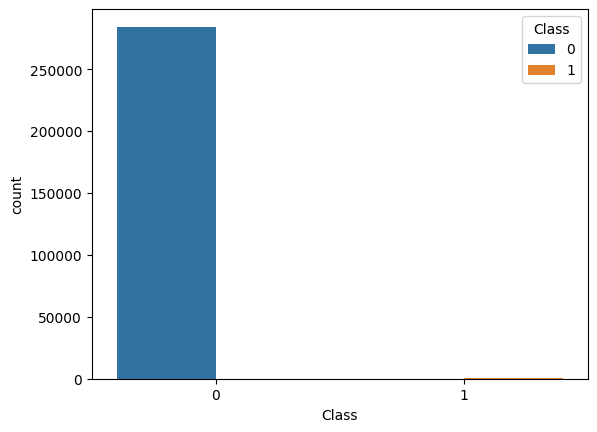

In [ ]:
sns.countplot(data = df, x = 'Class', hue = 'Class')

In [ ]:
from sklearn.utils import resample


df_majority = df[df['Class'] == 0]
df_minority = df[df['Class'] == 1]

In [ ]:
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=2*df_minority.shape[0],
                                   random_state= 25)

In [ ]:
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# check the new class distribution
print(df_balanced['Class'].value_counts())

0    984
1    492
Name: Class, dtype: int64


<Axes: xlabel='Class', ylabel='count'>

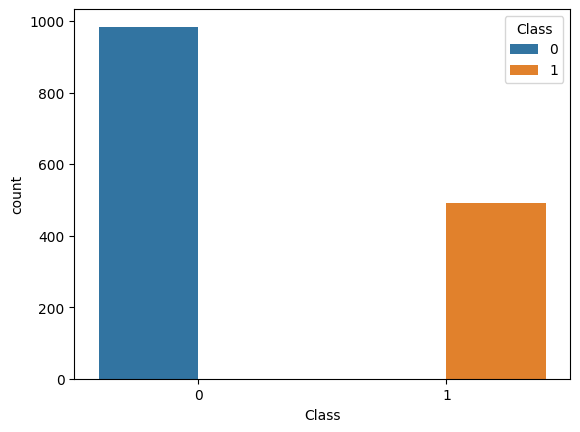

In [ ]:
#Plotting aftr Undersampling
sns.countplot(data = df_balanced, x = 'Class', hue = 'Class')

In [ ]:
df_balanced.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
270868,164303.0,-1.097222,0.353235,0.922740,-2.482786,-0.105249,-0.184947,-0.100673,0.481019,-1.062346,...,0.164649,0.328810,-0.498031,-1.043474,0.924309,-0.052164,0.128869,0.012683,23.80,0
140021,83493.0,-0.630556,0.920834,1.544361,-0.505343,0.282691,-0.792788,0.704038,0.070959,-0.672297,...,-0.150666,-0.609634,-0.071476,0.255576,-0.271271,-0.084206,0.041023,0.111986,0.99,0
20345,30974.0,-1.528035,-0.149136,1.630621,0.321879,0.965413,0.140374,0.718746,0.291817,-0.562373,...,0.102693,-0.045641,0.001520,-0.331837,0.756374,-0.396158,-0.018264,0.065365,128.00,0
256398,157672.0,-0.984714,1.567510,-1.346594,0.932186,1.561973,-0.202130,0.964876,0.303447,-0.989686,...,0.081396,0.447138,-0.020641,0.108025,0.155235,-0.407761,0.099543,0.201292,16.10,0
161202,113977.0,2.026669,-0.169353,-2.963794,-0.572662,2.602445,3.145164,-0.407581,0.782573,0.359077,...,-0.348086,-1.000637,0.357306,0.605186,-0.267133,0.218923,-0.040534,-0.041566,8.99,0


In [ ]:
from sklearn.preprocessing import StandardScaler

sd = StandardScaler()

In [ ]:
X = df_balanced.drop(['Class'], axis = 1)
Y = df_balanced['Class']

In [ ]:
print(X.shape, Y.shape)

(1476, 30) (1476,)


In [ ]:
X_scaled = sd.fit_transform(X)

In [ ]:
X_scaled = pd.DataFrame(X_scaled)
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.524141,0.100902,-0.277781,0.607735,-1.338946,0.266447,0.155632,0.357077,0.080593,-0.106420,...,0.044554,-0.031599,0.313908,-0.472234,-1.811623,1.464612,-0.100400,0.088439,-0.046318,-0.309314
1,-0.164376,0.198656,-0.103019,0.722981,-0.668529,0.374830,-0.212463,0.518336,-0.019185,0.080872,...,-0.264842,-0.164996,-0.572053,-0.041356,0.480802,-0.458851,-0.168397,-0.012830,0.216933,-0.406846
2,-1.261755,0.010658,-0.432459,0.738973,-0.388074,0.565570,0.352640,0.521283,0.034556,0.133654,...,0.141331,-0.057810,-0.039602,0.032381,-0.555802,1.194437,-0.830397,-0.081176,0.093341,0.136230
3,1.385587,0.124469,0.096091,0.187013,-0.181160,0.732237,0.145227,0.570606,0.037385,-0.071530,...,-0.218379,-0.066820,0.425619,0.009995,0.220419,0.227317,-0.855021,0.054631,0.453679,-0.342238
4,0.472584,0.755273,-0.438684,-0.112808,-0.691352,1.022925,2.172276,0.295575,0.153970,0.576110,...,-0.241571,-0.248516,-0.941189,0.391774,1.097756,-0.452194,0.474879,-0.106849,-0.190130,-0.372639


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.20, random_state= 25, shuffle= True)

In [ ]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score, recall_score, f1_score, precision_score

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier(n_estimators = 100)
xgb_clf.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_clf.predict(X_test)

#Print Classifaction Report
print('Classification Report:')
print(classification_report(y_test, y_pred))
print("Accuracy:")
print(accuracy_score(y_test, y_pred))
print("Recall:")
print(recall_score(y_test, y_pred))
print("F1 Score:")
print(f1_score(y_test, y_pred))
print("Precision:")
print(precision_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       200
           1       0.95      0.88      0.91        96

    accuracy                           0.95       296
   macro avg       0.95      0.93      0.94       296
weighted avg       0.95      0.95      0.95       296

Accuracy:
0.9459459459459459
Recall:
0.875
F1 Score:
0.9130434782608695
Precision:
0.9545454545454546


Confusion matrix:


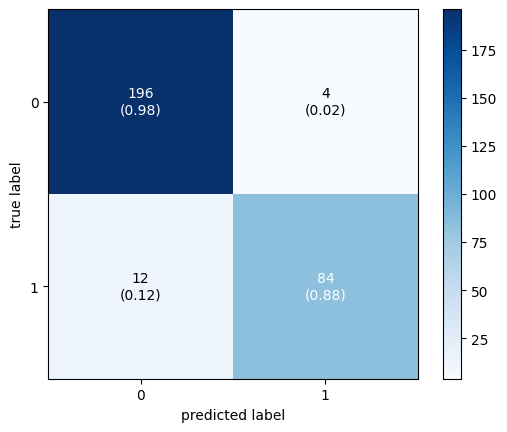

ROC-AUC score: 0.9765104166666667


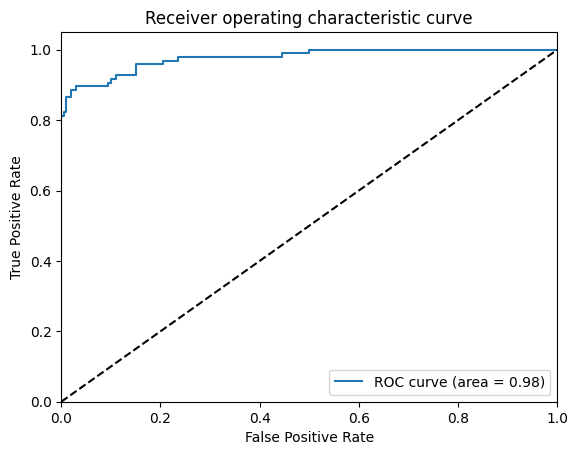

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
# Confusion matrix
conf_matrix = np.array(confusion_matrix(y_test, y_pred))
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


# ROC-AUC curve and score
y_prob = xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print('ROC-AUC score:', roc_auc)


# Plot ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty= 'l2')

In [ ]:
lr.fit(X_train, y_train)
# Predict on test set
y_pred_lr = xgb_clf.predict(X_test)


#Print Classifaction Report
print('Classification Report:')
print(classification_report(y_test, y_pred_lr))
print("Accuracy:")
print(accuracy_score(y_test, y_pred_lr))
print("Recall:")
print(recall_score(y_test, y_pred_lr))
print("F1 Score:")
print(f1_score(y_test, y_pred_lr))
print("Precision:")
print(precision_score(y_test, y_pred_lr))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       200
           1       0.95      0.88      0.91        96

    accuracy                           0.95       296
   macro avg       0.95      0.93      0.94       296
weighted avg       0.95      0.95      0.95       296

Accuracy:
0.9459459459459459
Recall:
0.875
F1 Score:
0.9130434782608695
Precision:
0.9545454545454546


Confusion matrix:


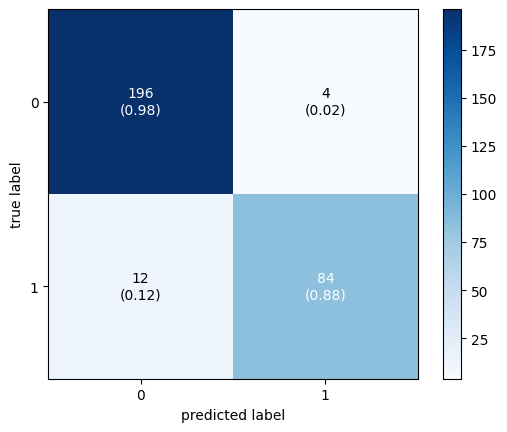

ROC-AUC score: 0.9717708333333334


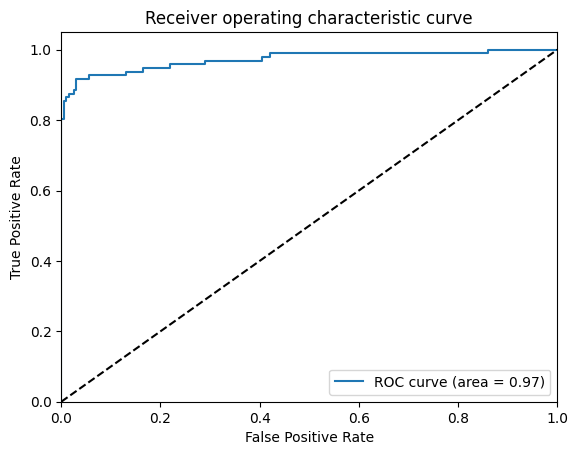

In [ ]:
# Confusion matrix
conf_matrix = np.array(confusion_matrix(y_test, y_pred_lr))
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


# ROC-AUC curve and score
y_prob_lr = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
roc_auc = roc_auc_score(y_test, y_prob_lr)
print('ROC-AUC score:', roc_auc)
# Plot ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

Neural Network Model

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create an instance of the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, activation = 'logistic')

# Train the MLPClassifier on the training data
mlp.fit(X_train, y_train)

# Evaluate the MLPClassifier on the testing data
score = mlp.score(X_test, y_test)
print("MLPClassifier accuracy: {:.2f}%".format(score * 100))

MLPClassifier accuracy: 94.93%


In [ ]:
# Predict on test set
y_pred_mlp = mlp.predict(X_test)


#Print Classifaction Report
print('Classification Report:')
print(classification_report(y_test, y_pred_mlp))
print("Accuracy:")
print(accuracy_score(y_test, y_pred_mlp))
print("Recall:")
print(recall_score(y_test, y_pred_mlp))
print("F1 Score:")
print(f1_score(y_test, y_pred_mlp))
print("Precision:")
print(precision_score(y_test, y_pred_mlp))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       200
           1       0.97      0.88      0.92        96

    accuracy                           0.95       296
   macro avg       0.95      0.93      0.94       296
weighted avg       0.95      0.95      0.95       296

Accuracy:
0.9493243243243243
Recall:
0.875
F1 Score:
0.9180327868852458
Precision:
0.9655172413793104


Confusion matrix:


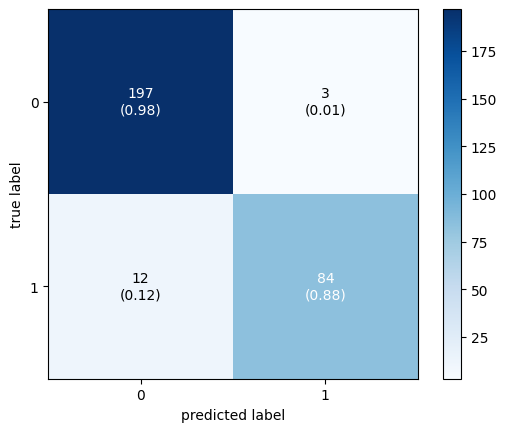

ROC-AUC score: 0.9731770833333334


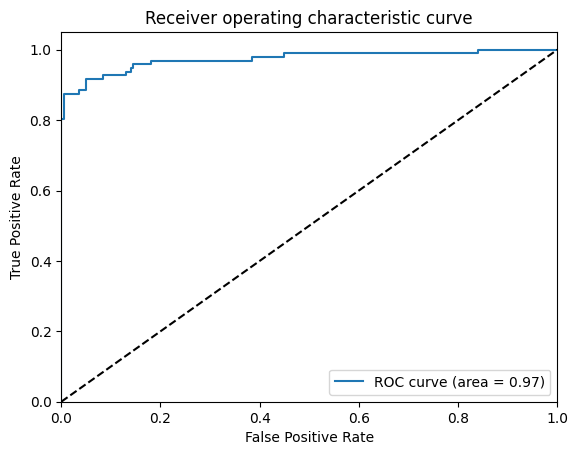

In [ ]:
# Confusion matrix
conf_matrix = np.array(confusion_matrix(y_test, y_pred_mlp))
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


# ROC-AUC curve and score
y_prob_mlp = mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_mlp)
roc_auc = roc_auc_score(y_test, y_prob_mlp)
print('ROC-AUC score:', roc_auc)


# Plot ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
nRow, nCol = df.shape

In [ ]:
print(f'There are {nRow} rows and {nCol} columns')

There are 284807 rows and 31 columns


In [ ]:
df["Class"]=df["Class"].astype("category")

In [ ]:
print("Total None values:", df.isna().any().sum())

Total None values: 0


In [ ]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
#Split the dataset
X = df.drop("Class", axis=1)
y=df["Class"].values
rand_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=rand_state, stratify=y)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the transaction data
df = pd.read_csv('transaction_data.csv')

# Split the data into features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict the target values for the test data
y_pred = rf.predict(X_test)

# Print the accuracy score and confusion matrix
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:', confusion_matrix(y_test, y_pred))